In [1]:
# Imports for Analysis
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import hvplot.pandas

# Imports for API 
import requests
import json
from api_keys import geoapify_key

In [12]:
# Import the csv file
file_path = './Resources/global_electricity_production_data.csv'
original_df = pd.read_csv(file_path)

# Create a column for the year
original_df['Year'] = original_df['date'].str.split('/').str[-1]

# Display the first 12 rows to show all of the different products
original_df.head(13)

,country_name,date,parameter,product,value,unit,Year
0,Australia,12/1/2023,Net Electricity Production,Electricity,22646.19,GWh,2023
1,Australia,12/1/2023,Net Electricity Production,Total Combustible Fuels,13397.94,GWh,2023
2,Australia,12/1/2023,Net Electricity Production,"Coal, Peat and Manufactured Gases",9768.52,GWh,2023
3,Australia,12/1/2023,Net Electricity Production,Oil and Petroleum Products,289.54,GWh,2023
4,Australia,12/1/2023,Net Electricity Production,Natural Gas,3091.93,GWh,2023
5,Australia,12/1/2023,Net Electricity Production,Combustible Renewables,247.94,GWh,2023
6,Australia,12/1/2023,Net Electricity Production,Hydro,1047.85,GWh,2023
7,Australia,12/1/2023,Net Electricity Production,Wind,2719.25,GWh,2023
8,Australia,12/1/2023,Net Electricity Production,Solar,5481.15,GWh,2023
9,Australia,12/1/2023,Net Electricity Production,"Total Renewables (Hydro, Geo, Solar, Wind, Other)",9496.20,GWh,2023


# How does the US compare to other countries in terms of electricity production?

In [13]:
# Filter the raw dataframe down to only total production of electricity
production_filter = (original_df['parameter'] == 'Net Electricity Production')&(original_df['product']=='Electricity')
production_df = original_df[production_filter]

# Display dataframe
production_df.head()

,country_name,date,parameter,product,value,unit,Year
0,Australia,12/1/2023,Net Electricity Production,Electricity,22646.19,GWh,2023
13,Austria,12/1/2023,Net Electricity Production,Electricity,6783.27,GWh,2023
31,Belgium,12/1/2023,Net Electricity Production,Electricity,6799.11,GWh,2023
49,Canada,12/1/2023,Net Electricity Production,Electricity,55982.22,GWh,2023
68,Chile,12/1/2023,Net Electricity Production,Electricity,7734.99,GWh,2023


In [18]:
# Group the dataframe by country and sum the value
production_by_country = production_df.groupby(['country_name','Year'])['value'].sum()
production_by_country_df = production_by_country.reset_index()

# Disable scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Display dataframe
production_by_country_df.head()

,country_name,Year,value
0,Argentina,2015,137590.83
1,Argentina,2016,139172.17
2,Argentina,2017,137915.23
3,Argentina,2018,139188.12
4,Argentina,2019,132462.31


In [28]:
# Filter down to the electricity production for 2023
production_by_country_2023_df = production_by_country_df[production_by_country_df['Year']=='2023']

# Drop unneeded year column
production_by_country_2023_df = production_by_country_2023_df.drop(columns='Year')

# Display first 5 rows in dataframe
production_by_country_2023_df.head()

,country_name,value
8,Argentina,130607.86
22,Australia,261570.59
36,Austria,67958.49
50,Belgium,78668.68
59,Brazil,690334.72


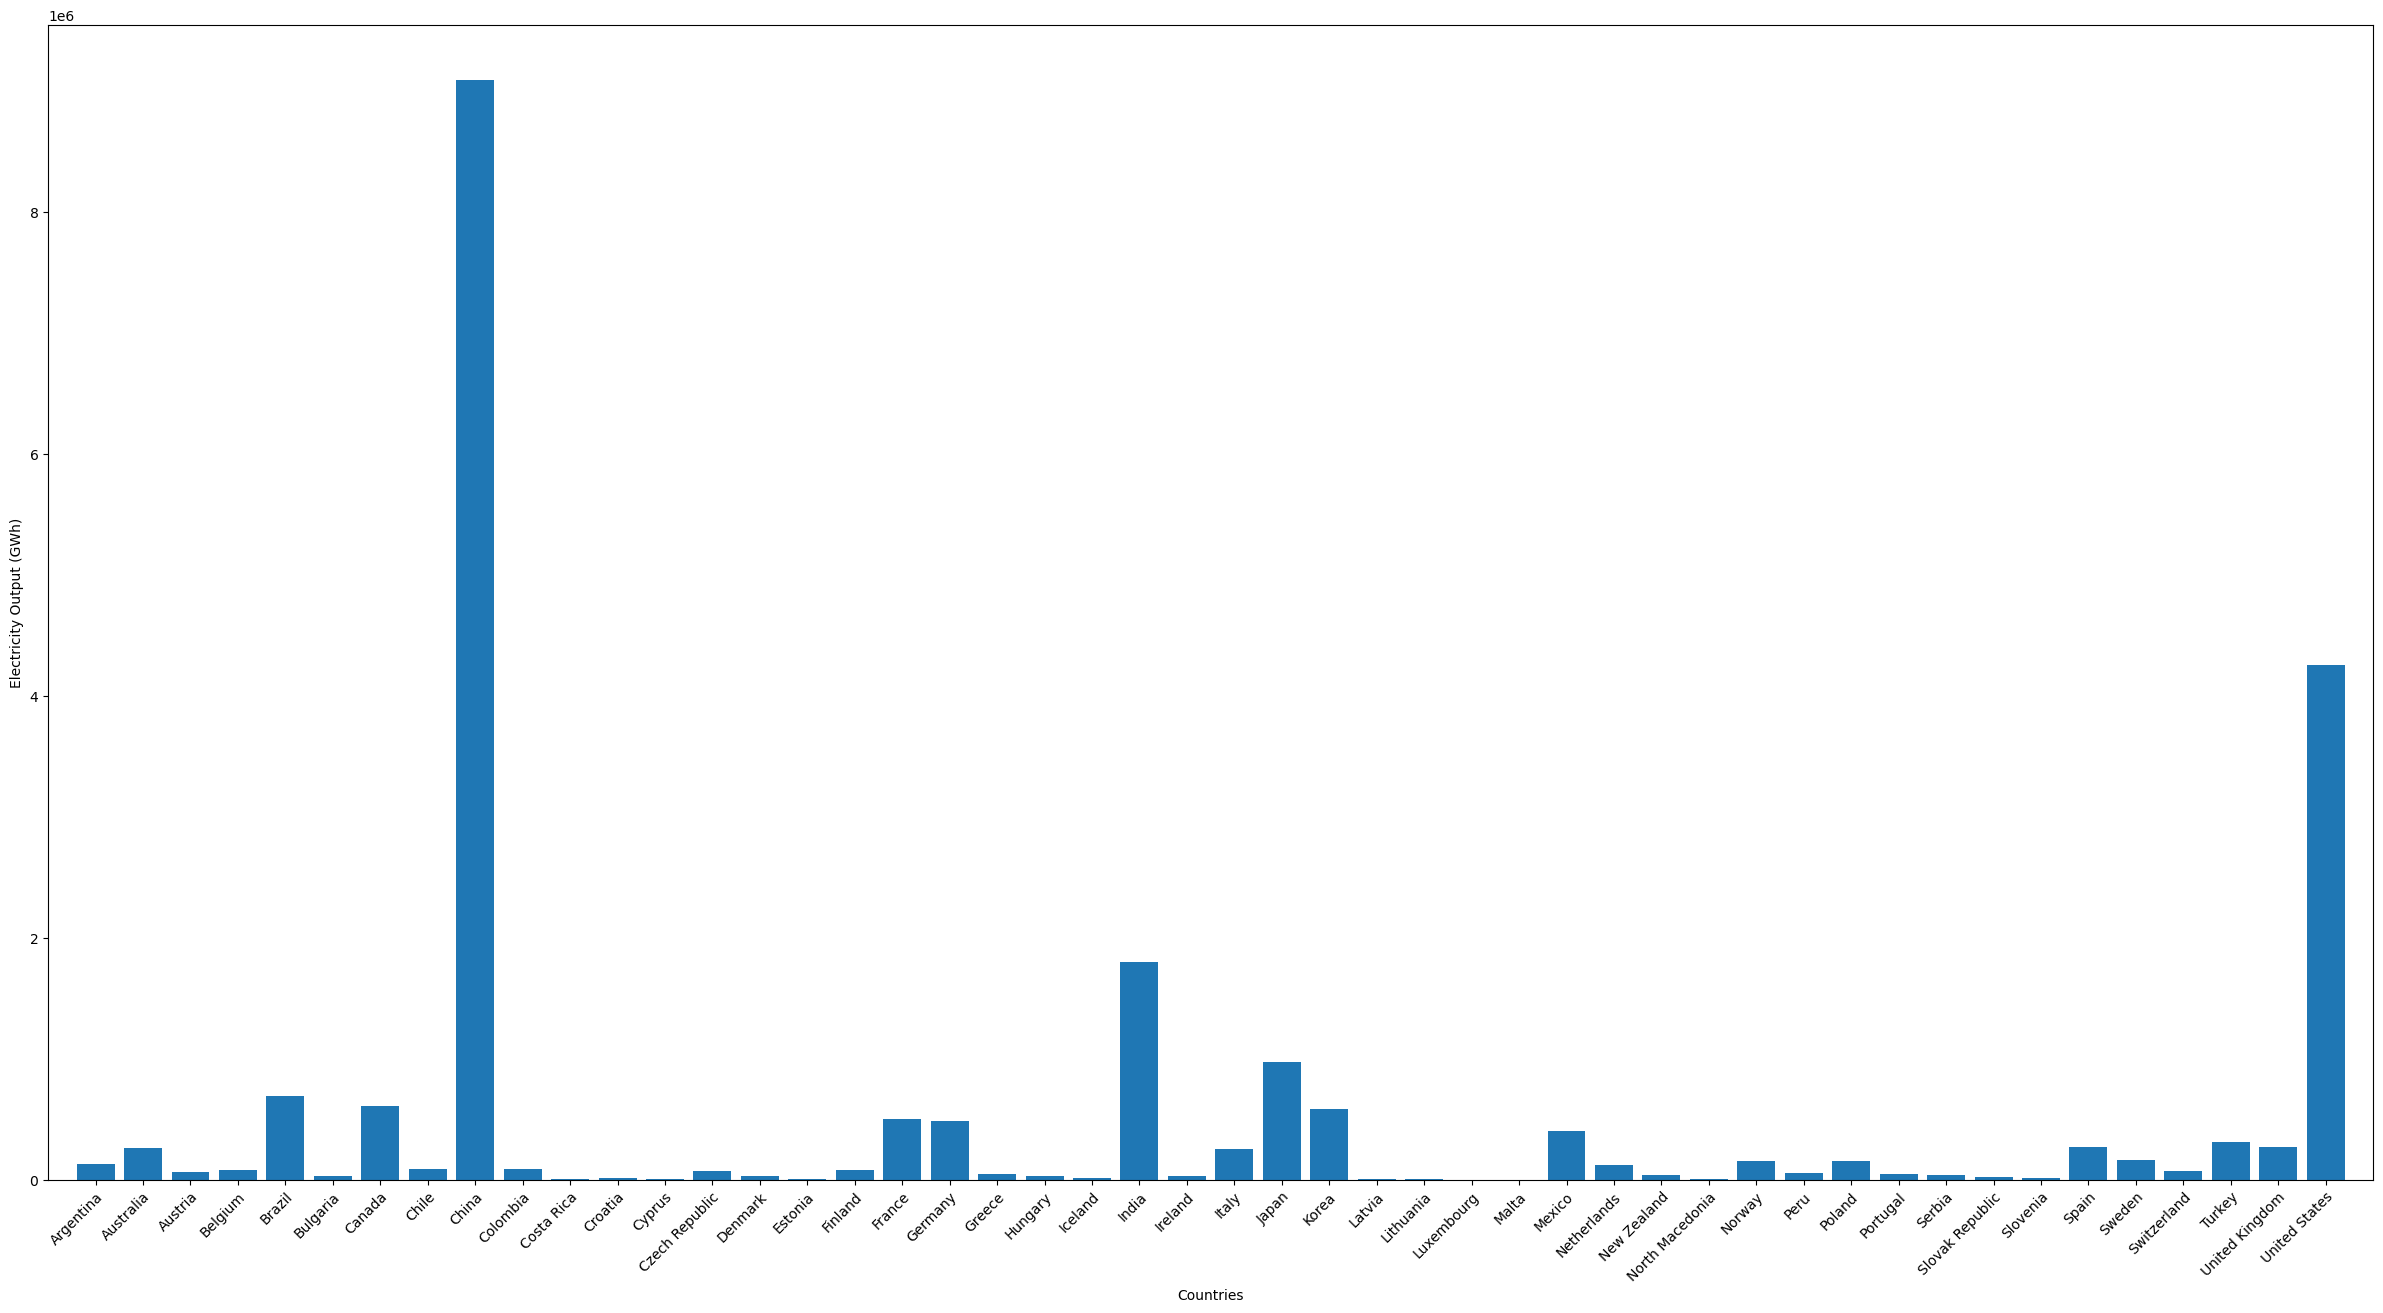

In [29]:
# Create a bar plot of all countries elerticity production in 2023
fig, ax = plt.subplots(figsize=(30,15))
ax.bar(production_by_country_2023_df['country_name'], production_by_country_2023_df['value'])

# Create labels
ax.set_xticks(ticks=production_by_country_2023_df['country_name'],labels=production_by_country_2023_df['country_name'],rotation_mode='anchor',ha='right', rotation=45)
ax.set_xlabel('Countries')
ax.set_ylabel('Electricity Output (GWh)')
ax.set_xlim(-1, 48)

# Display the plot
plt.show()

In [30]:
# Create lists for the latitudes and longitudes of each country
list_of_lats = []
list_of_lons = []

# Loop through Geoapify and extract the latitudes and longitudes of each country
for country in production_by_country_2023_df['country_name']:
    # Collect JSON request for a country in the dataframe
    query_url = f"https://api.geoapify.com/v1/geocode/search?text={country}&format=json&apiKey={geoapify_key}"
    json_response = requests.get(query_url).json()

    # Extract the lat and lons
    lat_response = json_response['results'][0]['lat']
    lon_response = json_response['results'][0]['lon']

    # Add them to each list
    list_of_lats.append(lat_response)
    list_of_lons.append(lon_response)

# Add the lats and lons to the dataframe
production_by_country_2023_df['lat'] = list_of_lats
production_by_country_2023_df['lon'] = list_of_lons

# Display dataframe
production_by_country_2023_df.head()

,country_name,value,lat,lon
8,Argentina,130607.86,-35.00,-64.97
22,Australia,261570.59,-24.78,134.75
36,Austria,67958.49,47.59,14.12
50,Belgium,78668.68,50.64,4.67
59,Brazil,690334.72,-10.33,-53.20


In [31]:
# Configure the map plot of each country with size based on electricity production in 2023
map_plot_1 = production_by_country_2023_df.hvplot.points('lon', 
                                          'lat', 
                                          geo=True,
                                          tiles='OSM',
                                          frame_width = 700,
                                          frame_height = 500,
                                          color ='country_name',
                                          size='value',
                                          alpha=.5,
                                          scale = .025)

# Display the map plot
map_plot_1 

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [lon,lat]   (country_name,value)

# How does population impact electricity production?

# How do the ratios of fossil fuel vs renewables for electricity compare in countries?

# What do we predict the future fossil fuel to renewable ratio will look like for the U.S.?